In [39]:
"""Some of this code is part of the deeplearning specialization course assignment from deeplearning.ai"""

'Some of this code is part of the deeplearning specialization course assignment from deeplearning.ai'

In [2]:
# import packages
import os
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [3]:
# Create the Dataset and Split it into Training and Validation Sets

BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


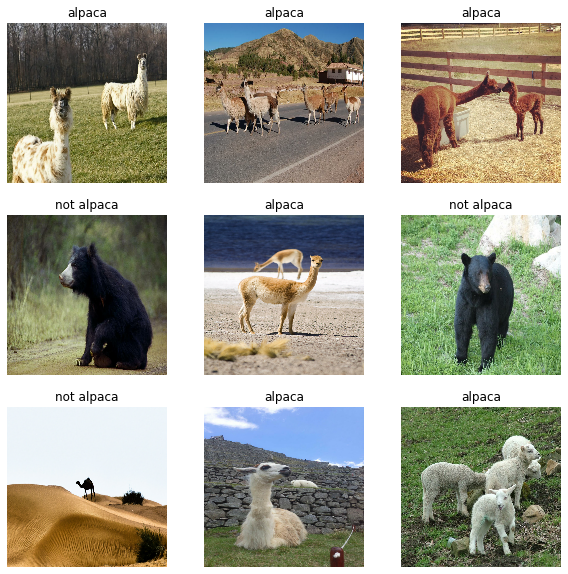

In [4]:
# Display some of the images from the training set:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

##### Preprocess and Augment Training Data

In [5]:
# prefetch() prevents a memory bottleneck that can occur when reading from disk.
# set the number of elements to prefetch using AUTOTUNE
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:

# data_augmenter
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))

    return data_augmentation

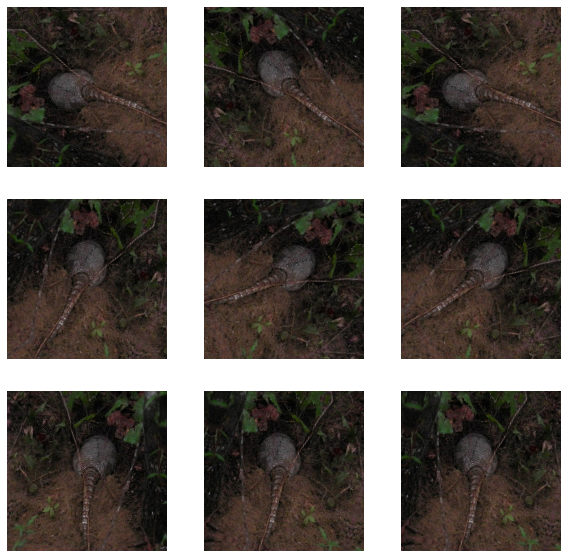

In [9]:
# Display augmented images from training set
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [10]:
# reuse the pretrained normalization values MobileNetV2 was trained on
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

#### Using MobileNetV2 for Transfer Learning

In [11]:
# load the pretrained weights from ImageNet by specifying weights='imagenet' with the tops
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

14548992/14536120 [==============================] - 2s 0us/step


In [12]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [14]:
# displaying top layers
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


In [16]:
# Experimental:  with MobileNetV2 base model, test out the predictions on some of the images. 
# to show need to reconfigure the top layers to 2 classes needed instead of 1000 model was trained on
# 32 = batchSize, 1000 = classes
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [17]:
# Experimental: Shows the different label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1])>

In [18]:
# Experimental: decode the predictions made by the model
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

49152/35363 [=========================================] - 0s 0us/step


[[('n02437616', 'llama', 0.7829218), ('n02415577', 'bighorn', 0.04114266)],
 [('n04371774', 'swing', 0.26494288), ('n01877812', 'wallaby', 0.0677156)],
 [('n02437616', 'llama', 0.553087), ('n02115913', 'dhole', 0.061228268)],
 [('n02437616', 'llama', 0.44629836), ('n02410509', 'bison', 0.20282738)],
 [('n02110341', 'dalmatian', 0.06487803),
  ('n02128385', 'leopard', 0.041099157)],
 [('n04326547', 'stone_wall', 0.09115206),
  ('n02415577', 'bighorn', 0.08460592)],
 [('n03868242', 'oxcart', 0.43485925), ('n02403003', 'ox', 0.20809531)],
 [('n02095570', 'Lakeland_terrier', 0.37483537),
  ('n02090721', 'Irish_wolfhound', 0.097030565)],
 [('n02437616', 'llama', 0.66374195), ('n02115913', 'dhole', 0.022451691)],
 [('n02437312', 'Arabian_camel', 0.25663662),
  ('n02422106', 'hartebeest', 0.12122731)],
 [('n02437616', 'llama', 0.99701285), ('n02412080', 'ram', 0.0005227616)],
 [('n02110341', 'dalmatian', 0.30556065),
  ('n02100735', 'English_setter', 0.04968587)],
 [('n02093647', 'Bedlington_

The incorrect labels are due to the fact that MobileNet, which was pretrained on the ImageNet dataset, does not include the correct labels for alpacas. Consequently, when using the full model, the classification results for alpaca images are inaccurate, resulting in a collection of misclassified images.

#### Layer Freezing with the Functional API

In [19]:
# -Delete the top layer (the classification layer
# -Add a new classifier layer; a single neuron binary classification
# -Freeze the base model and train the newly-created classifier layer

def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    input_shape = image_shape + (3,)
 
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
   
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x)
     
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # include dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.Dropout(0.2)(x) 
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tf.keras.layers.Dense(1)(x)
    
    ### END CODE HERE
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [20]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)
model2.summary()

9420800/9406464 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                         

In [22]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 9s 849ms/step - loss: 0.3939 - accuracy: 0.8130 - val_loss: 0.2920 - val_accuracy: 0.8308
Epoch 2/5
9/9 [==============================] - 9s 817ms/step - loss: 0.3525 - accuracy: 0.8321 - val_loss: 0.2661 - val_accuracy: 0.8615
Epoch 3/5
9/9 [==============================] - 9s 806ms/step - loss: 0.3063 - accuracy: 0.8588 - val_loss: 0.2456 - val_accuracy: 0.8769
Epoch 4/5
9/9 [==============================] - 8s 787ms/step - loss: 0.3230 - accuracy: 0.8206 - val_loss: 0.2447 - val_accuracy: 0.8769
Epoch 5/5
9/9 [==============================] - 8s 756ms/step - loss: 0.3272 - accuracy: 0.8206 - val_loss: 0.2357 - val_accuracy: 0.8615


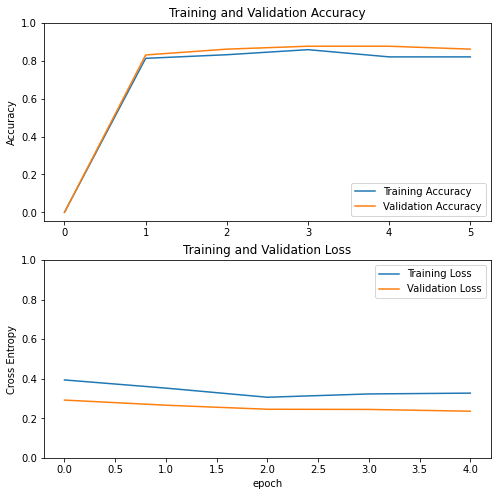

In [29]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
class_names

['alpaca', 'not alpaca']

### Fine-tuning the Model

In [35]:
# Fine-tuning the Model:
# unfreeze the final layers and re-run the optimizer with a smaller learning rate, 
# while keeping all the other layers frozen.

base_model = model2.layers[4]
base_model.trainable = True

# See how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

### START CODE HERE

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = optimizer=tf.keras.optimizers.Adam(lr=0.1*base_learning_rate)
# Use accuracy as evaluation metric
metrics=['accuracy']

### END CODE HERE

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  154


In [36]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 30s 1s/step - loss: 0.4516 - accuracy: 0.7748 - val_loss: 0.2881 - val_accuracy: 0.8000
Epoch 6/10
9/9 [==============================] - 10s 980ms/step - loss: 0.2778 - accuracy: 0.8626 - val_loss: 0.1920 - val_accuracy: 0.9231
Epoch 7/10
9/9 [==============================] - 10s 937ms/step - loss: 0.1881 - accuracy: 0.9351 - val_loss: 0.2687 - val_accuracy: 0.8000
Epoch 8/10
9/9 [==============================] - 10s 988ms/step - loss: 0.2191 - accuracy: 0.8969 - val_loss: 0.1266 - val_accuracy: 0.9077
Epoch 9/10
9/9 [==============================] - 10s 938ms/step - loss: 0.1957 - accuracy: 0.9427 - val_loss: 0.0549 - val_accuracy: 0.9846
Epoch 10/10
9/9 [==============================] - 10s 961ms/step - loss: 0.1113 - accuracy: 0.9580 - val_loss: 0.0495 - val_accuracy: 1.0000


In [37]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

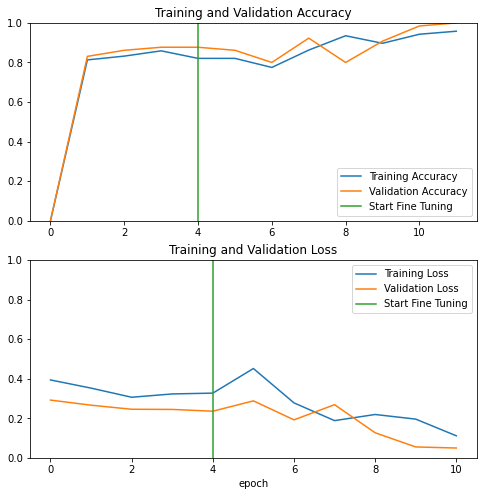

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Reference:
    Deeplearning specialization from deeplearning.ai